![PNS](http://caillau.perso.math.cnrs.fr/logo-pns.png)
## MAM4 - EDP1
# TP 3 - Équation de la chaleur 2D


On souhaite simuler l'évolution de la température dans une pièce en forme de L
- dont le chauffage se situe dans la partie supérieure,
- dont les parois sont isolantes,
- à l'exception d'une fenêtre située sur le mur du bas.

On rappelle que cette température suit l'EDP de la chaleur 2D :

$$ \frac{\partial u}{\partial t}(x,y,t) - \nu\Delta u(x,y,t) = f(x,y),\quad (x,y) \in \Omega,\quad t > 0,\\
u(x,y,0)=u_0(x,y), $$

avec des conditions aux limites appropriées sur le bord du domaine.

## Exercice 1
Compléter le code ci-dessous de façon à prendre en compte :
- le chauffage dans la zone $(0.6,0.9) \times (0.8,1)$,
- le fait que les parois sont isolantes (Neumann homogène),
- à l'exception de la fenêtre située entre $x=0.25$ et $x=0.75$ (Dirichlet inhomogène).

In [1]:
using SparseArrays

# Discrete 2D Laplacian - works with arbitrary ordering of interior nodes
function laplacian(G; Δx=1.0, Δy=1.0)
    ij = findall(G .≠ 0)
    K = length(ij)
    p = sortperm(G[ij])
    ij = ij[p] # ij is reordered so that G[ij[k]] = k
    Δ = spzeros(K, K)
    for k = 1:K
        Δ[k, k] = -2/Δx^2-2/Δy^2
        ijₖ = ij[k]
        kW = G[ijₖ + CartesianIndex(0, -1)]
        if kW ≠ 0 Δ[k, kW] = 1/Δx^2 end
        kE = G[ijₖ + CartesianIndex(0,  1)]
        if kE ≠ 0 Δ[k, kE] = 1/Δx^2 end
        kS = G[ijₖ + CartesianIndex(-1, 0)]
        if kS ≠ 0 Δ[k, kS] = 1/Δy^2 end
        kN = G[ijₖ + CartesianIndex( 1, 0)]
        if kN ≠ 0 Δ[k, kN] = 1/Δy^2 end
    end
    return Δ
end

# Mesh generation
function meshgrid(x, y)
    n = length(x)
    m = length(y)
    xx = zeros(1, n)
    xx[:] = x
    yy = zeros(m, 1)
    yy[:] = y
    X = ones(m, 1) * xx
    Y = yy * ones(1, n)
    return (X, Y)
end

meshgrid (generic function with 1 method)

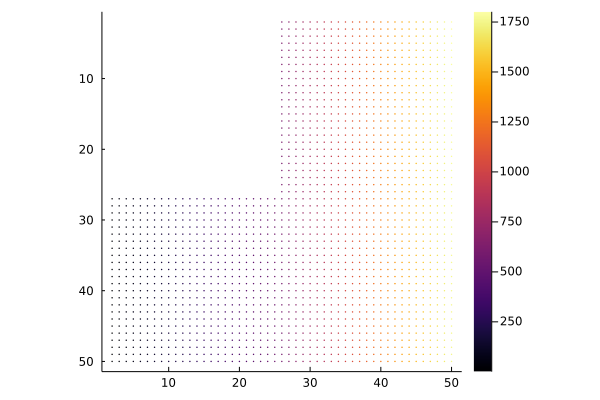

In [2]:
using Random, LinearAlgebra, Plots; gr()

# Grid generation
ν = 1
Nx = 50
Ny = Nx
Nt = 400
σ = 1 # CFL
x = range(0, 1, length=Nx+1) # Ω is L-shaped included in (0,1)x(0,1)
y = range(0, 1, length=Ny+1)
uw = -1 # window temperature
f = 50 # heating
Δx = x[2]-x[1]
Δy = y[2]-y[1]
Δt = σ*Δx^2/ν
tf = Nt*Δt
(X, Y) = meshgrid(x, y)
ij = findall( (X .< 1) .& (Y .> 0) .& ( ( (X .> 0) .& (Y .< 0.5) ) .| ( (X .≥ 0.5) .& (Y .< 1) ) ) )
K = length(ij)
G = zeros(Int, size(X))
G[ij] = 1:K # columnwise ordering of interior nodes
spy(G[end:-1:1, :])

In [15]:
# Assembly
A = -laplacian(G, Δx=Δx, Δy=Δy)
b = ones(K) # TO BE UPDATED

for k = 1:K # Neumann everywhere...
    ijₖ = ij[k]
    kW = G[ijₖ + CartesianIndex(0, -1)]
    if kW == 0 A[k, k] = A[k, k] end # TO BE UPDATED
    kE = G[ijₖ + CartesianIndex(0,  1)]
    if kE == 0 A[k, k] = A[k, k] end # TO BE UPDATED
    kS = G[ijₖ + CartesianIndex(-1, 0)]
    if kS == 0
        if (X[ijₖ] ≥ 0.25) && (X[ijₖ] ≤ 0.75) # ... but on the window
            b[k] = b[k] # TO BE UPDATED
        else
            A[k, k] = A[k, k] # TO BE UPDATED           
        end
    end
    kN = G[ijₖ + CartesianIndex( 1, 0)]
    if kN == 0 A[k, k] = A[k, k] end # TO BE UPDATED
end

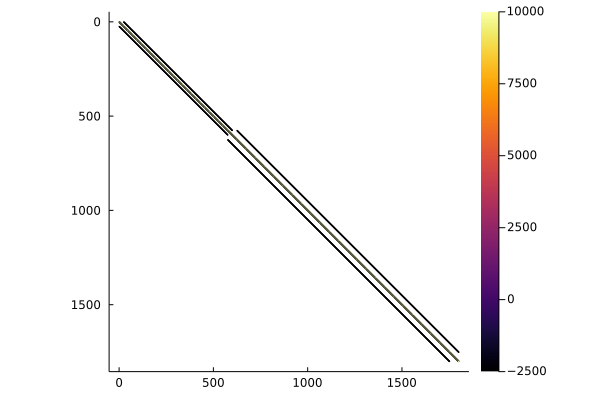

In [16]:
# Solve
F = lu(A) # LU factorisation of sparse A (not assuming any symmetry)
u = F\b
U = zeros(size(G))
U[ij] = u[G[ij]]
spy(A)

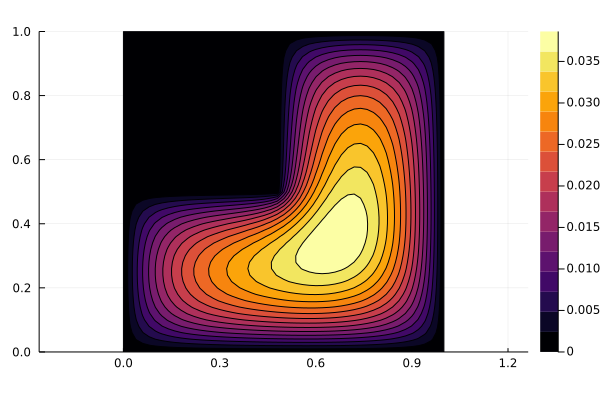

In [17]:
# Plots
p1 = contour(x, y, U, fill=true, aspect_ratio=:equal)
display(p1)

## Exercice 2
Calculer l'évolution temporelle de la température à l'aide du schéma de Crank-Nicolson 2D.